<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Final/Grid_Test_European_Call_1stock_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
Thedataset = pd.read_csv('European_Call_1stock_MC_Datset.csv', header=None)
Thedataset

,0,1,2,3,4,5,6,7
0,1.0,0.75,0.75,0.150,0.01,0.01,0.048459,0.556185
1,1.0,0.75,0.75,0.225,0.01,0.01,0.070662,0.562336
2,1.0,0.75,0.75,0.300,0.01,0.01,0.092787,0.572583
3,1.0,0.75,0.75,0.375,0.01,0.01,0.114793,0.584748
4,1.0,0.75,0.75,0.450,0.01,0.01,0.136644,0.597456
...,...,...,...,...,...,...,...,...
1495,1.0,1.25,1.25,0.150,0.04,0.04,0.100371,0.633561
1496,1.0,1.25,1.25,0.225,0.04,0.04,0.136027,0.613980
1497,1.0,1.25,1.25,0.300,0.04,0.04,0.171954,0.611451
1498,1.0,1.25,1.25,0.375,0.04,0.04,0.207843,0.615662


# Construct Neural Net

In [2]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:6]
Thedataset_Y = Thedataset.iloc[:,6:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# # print
# ds = OptionDataSet(max_len = 1)
# for i in ds:
#     print(i[0])
#     print(i[0].shape)
#     print(i[1])
#     print(i[1].shape)

In [10]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, 32) # remember to change this!
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 2) # 1 outputs: price,delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.3, 0.03, 0.03]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.75, 0.15, 0.01, 0.01]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


# Train Neural Net

In [4]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 5.3 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 200) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[2, 8, 14]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # # print(deltas)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 500)

model_save_name = 'jax_european_1stock_1.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.17612987103277752 average time 0.0044884977499691555 iter num 20
loss 0.08875361435760996 average time 0.004854893949993766 iter num 40
loss 0.049578734650644364 average time 0.005341691816670391 iter num 60
loss 0.04412212335937423 average time 0.005198251012501487 iter num 80
loss 0.04227000228497914 average time 0.005210084939999433 iter num 100
loss 0.040775875059498985 average time 0.0051222139833347075 iter num 120
loss 0.03977844443753208 average time 0.005028621628574521 iter num 140
loss 0.03919168754775054 average time 0.005009526287504684 iter num 160
loss 0.038929139381839985 average time 0.0049662396722245225 iter num 180
loss 0.038853184222467994 average time 0.004950487960003329 iter num 200
loss 0.035020297394525134 average time 0.004859174000000621 iter num 20
loss 0.030503564992928223 average time 0.004960396275004086 iter num 40
loss 0.025529809340642348 average time 0.004751467833318657 iter num 60
loss 0.02050221179924931 average time 0.004809193324976491 it

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
model_save_name = 'jax_european_1stock_1.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import torch
model_save_name = 'jax_european_1stock_1.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [13]:
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=2, bias=True)
)


#Results

In [14]:
import torch
inputs = torch.tensor([[1, 1, 1, 0.25, 0.02, 0.02]]).cuda() # T, K, S, sigma, mu, r
#model(inputs.float())[0]
print('price: ' + str(model(inputs.float())[0][0]))
print('delta: ' + str(model(inputs.float())[0][1]))


# price, delta
# should be around (0.10870558, 0.581213937)

price: tensor(0.108865, device='cuda:0', grad_fn=<SelectBackward0>)
delta: tensor(0.581151, device='cuda:0', grad_fn=<SelectBackward0>)


In [15]:
import cupy
import numpy as np
from torch.utils.dlpack import from_dlpack
from scipy.stats import norm
from math import log, sqrt, pi, exp
import pandas as pd

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))

print(bs_call(1,1,1,0.02,0.25))
print(bs_delta(1,1,1,0.02,0.25))

0.10870558490557591
0.5812139374874482


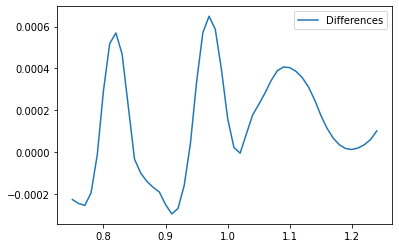

In [17]:
from scipy.stats import norm
from math import log, sqrt, pi, exp
import matplotlib.pyplot as plt
import numpy as np

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def compute_price(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())

prices = np.arange(0.75, 1.25, 0.01)
jax_call_prices = []
BS_call_prices = []
for p in prices:
    jax_call_prices.append(compute_price(p)[0][0])
    BS_call_prices.append(bs_call(p, 1, 1, 0.02, 0.25))


plt.plot(prices, np.array(jax_call_prices)-np.array(BS_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

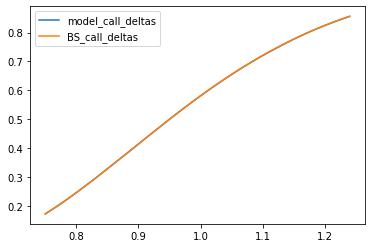

In [32]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

K = 1
def compute_delta(S):
    inputs = torch.tensor([[1, K, S, 0.25, 0.02, 0.02]]).cuda()
    x = model(inputs.float())
    return x[0][1]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()

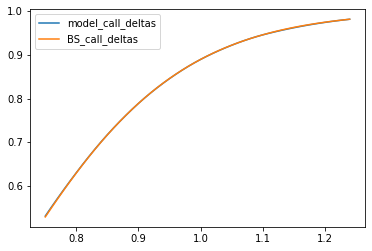

In [33]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

K = 0.775
def compute_delta(S):
    inputs = torch.tensor([[1, K, S, 0.25, 0.02, 0.02]]).cuda()
    x = model(inputs.float())
    return x[0][1]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 0.775, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()

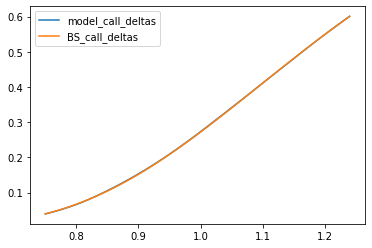

In [34]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

K = 1.225
def compute_delta(S):
    inputs = torch.tensor([[1, K, S, 0.25, 0.02, 0.02]]).cuda()
    x = model(inputs.float())
    return x[0][1]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1.225, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()

# Comparison on Speed

In [27]:
# Monte Carlo Simulation with Jax
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T):
  return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

numstocks = 3
numsteps = 50
numpaths = 100000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([100.]*numstocks) # must be float
T = 1.0
K = 110.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))


# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)

In [30]:
initial_stocks = jnp.array([1.]*numstocks)
K = 1
#%timeit bs_delta(initial_stocks,K,1,0.02,0.25)
%timeit goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T)
%timeit compute_delta(1).item()

The slowest run took 228.61 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 26.4 ms per loop
The slowest run took 271.45 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 808 µs per loop
